In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## GPU Check (Skip if enabled)

In [ ]:
import tensorflow as tf

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")


Default GPU Device: /device:GPU:0


In [ ]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import mobilenet_v3_small
import torch.nn as nn
import torch.optim as optim

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [ ]:
# Read the CSV file
df = pd.read_csv("/content/drive/MyDrive/Image Dataset Curation/Image_Dataset_Final.csv")
df['datetime'] = pd.to_datetime(df['datetime'])

#Renaming the columns
df = df.rename(columns={'image_path': 'filename', 'Avg Global CMP22 (vent/cor) [W/m^2]': 'irradiance'})

df = df.sort_values(by='datetime')


df.head()

,filename,datetime,irradiance
0,/content/drive/MyDrive/Image Dataset Curation/...,2021-10-08 07:00:00,63.8407
1,/content/drive/MyDrive/Image Dataset Curation/...,2021-10-08 08:00:00,176.1522
2,/content/drive/MyDrive/Image Dataset Curation/...,2021-10-08 09:00:00,361.7695
3,/content/drive/MyDrive/Image Dataset Curation/...,2021-10-08 10:00:00,582.2481
4,/content/drive/MyDrive/Image Dataset Curation/...,2021-10-08 11:00:00,632.4995


### Model 1 - First Try

Found 5767 validated image filenames.
Found 1442 validated image filenames.


Epoch 1/50
181/181 [==============================] - 88s 465ms/step - loss: 198964.7812 - val_loss: 251909.5469
Epoch 2/50
181/181 [==============================] - 77s 424ms/step - loss: 170871.0000 - val_loss: 221113.2500
Epoch 3/50
181/181 [==============================] - 75s 417ms/step - loss: 147605.5781 - val_loss: 195578.2344
Epoch 4/50
181/181 [==============================] - 73s 401ms/step - loss: 128722.7344 - val_loss: 174242.9531
Epoch 5/50
181/181 [==============================] - 90s 496ms/step - loss: 113408.6250 - val_loss: 156600.3750
Epoch 6/50
181/181 [==============================] - 71s 392ms/step - loss: 101223.8516 - val_loss: 142272.8594
Epoch 7/50
181/181 [==============================] - 74s 410ms/step - loss: 91727.9609 - val_loss: 130738.4375
Epoch 8/50
181/181 [==============================] - 79s 439ms/step - loss: 84399.3828 - val_loss: 121681.3438
Epoch 9/50
181/181 [==============================] - 72s 396ms/step - loss: 78849.6328 - val_loss

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


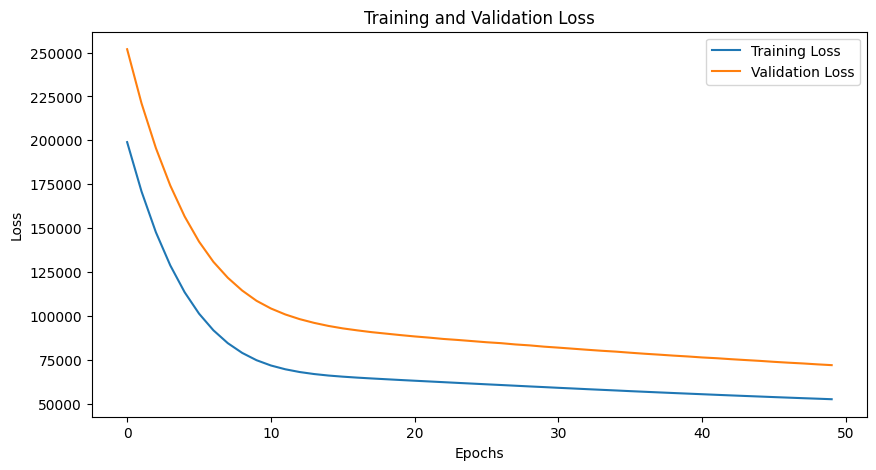

In [ ]:
from sklearn.model_selection import train_test_split

split_index = int(len(df) * 0.8)
train_df = df[:split_index]
val_df = df[split_index:]


# Data generators
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='irradiance',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    shuffle=False  # Important for time series data
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='irradiance',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    shuffle=False  # Important for time series data
)


# Load pre-trained MobileNetV3 model
base_model = tf.keras.applications.MobileNetV3Small(weights='imagenet', include_top=False)

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for regression
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(1)(x)  # 1 output neuron for regression
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(train_generator, epochs=50, validation_data=val_generator)

# Save the model
model.save('solar_irradiance_predictor.h5')

# Plotting Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


46/46 [==============================] - 18s 386ms/step


<ipython-input-14-3c335db5f1f2>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['predicted_irradiance'] = predicted_irradiance


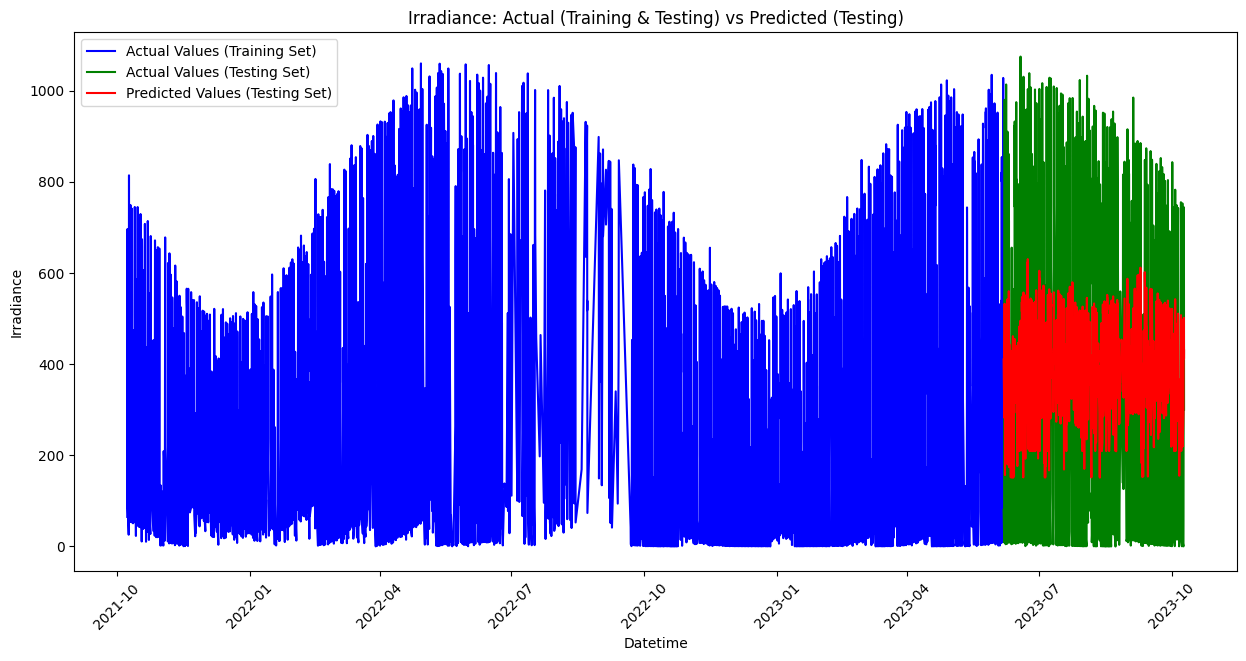

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming train_df and val_df are already created using the sequential split
# Predicting values for the validation set
predicted_irradiance = model.predict(val_generator).flatten()

# Add the predicted values to val_df
val_df['predicted_irradiance'] = predicted_irradiance

# Plotting
plt.figure(figsize=(15, 7))

# Plot actual values from the training set
plt.plot(train_df['datetime'], train_df['irradiance'], label='Actual Values (Training Set)', color='blue')

# Plot actual values from the testing set
plt.plot(val_df['datetime'], val_df['irradiance'], label='Actual Values (Testing Set)', color='green')

# Plot predicted values from the testing set
plt.plot(val_df['datetime'], val_df['predicted_irradiance'], label='Predicted Values (Testing Set)', color='red')

plt.title('Irradiance: Actual (Training & Testing) vs Predicted (Testing)')
plt.xlabel('Datetime')
plt.ylabel('Irradiance')
plt.legend()
plt.xticks(rotation=45)
plt.show()


### Model 2

Found 5767 validated image filenames.
Found 1442 validated image filenames.


Epoch 1/40
181/181 [==============================] - ETA: 0s - loss: 198832.1875 - mean_absolute_error: 352.5179 - mean_squared_error: 198832.1875

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


181/181 [==============================] - 1908s 10s/step - loss: 198832.1875 - mean_absolute_error: 352.5179 - mean_squared_error: 198832.1875 - val_loss: 251695.8438 - val_mean_absolute_error: 393.4048 - val_mean_squared_error: 251695.8438
Epoch 2/40
181/181 [==============================] - 74s 406ms/step - loss: 170811.1875 - mean_absolute_error: 320.2079 - mean_squared_error: 170811.1875 - val_loss: 221268.0312 - val_mean_absolute_error: 366.7585 - val_mean_squared_error: 221268.0312
Epoch 3/40
181/181 [==============================] - 74s 408ms/step - loss: 147936.5000 - mean_absolute_error: 295.3679 - mean_squared_error: 147936.5000 - val_loss: 195687.2344 - val_mean_absolute_error: 345.6504 - val_mean_squared_error: 195687.2344
Epoch 4/40
181/181 [==============================] - 71s 390ms/step - loss: 128883.0469 - mean_absolute_error: 275.5048 - mean_squared_error: 128883.0469 - val_loss: 174152.5000 - val_mean_absolute_error: 328.7364 - val_mean_squared_error: 174152.5000

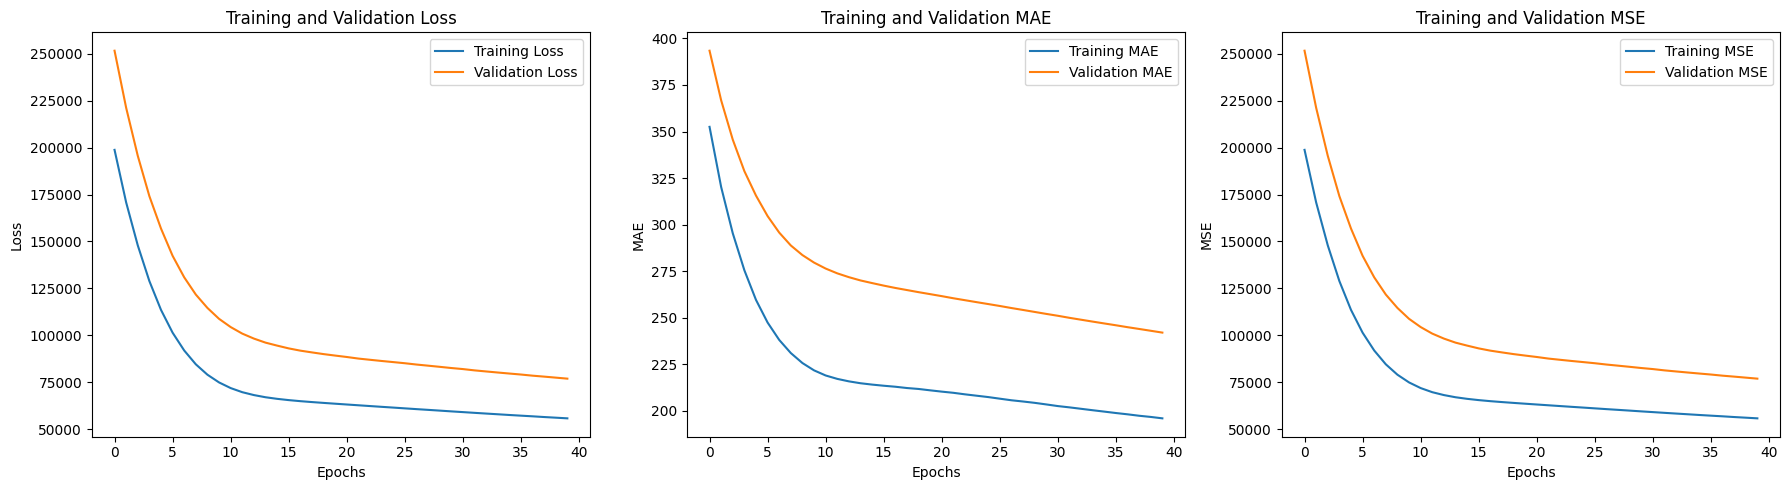

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# Reading the CSV file
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Image Dataset Curation/Image_Dataset_Final.csv")
df['datetime'] = pd.to_datetime(df['datetime'])

# Renaming the columns
df = df.rename(columns={'image_path': 'filename', 'Avg Global CMP22 (vent/cor) [W/m^2]': 'irradiance'})

# Sorting the values by datetime
df = df.sort_values(by='datetime')

# Splitting the data into training and validation sets
split_index = int(len(df) * 0.8)
train_df = df[:split_index]
val_df = df[split_index:]

# Data augmentation and preprocessing for training data
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
)

# Preprocessing for validation data (without augmentation)
val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
)

# Data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='irradiance',
    target_size=(224, 224),  # Resizing images
    batch_size=32,
    class_mode='raw',
    shuffle=False  # Important for time series data
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='irradiance',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    shuffle=False
)

# Load pre-trained MobileNetV3 model
base_model = tf.keras.applications.MobileNetV3Small(weights='imagenet', include_top=False)

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for regression
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(1)(x)  # 1 output neuron for regression
model = Model(inputs=base_model.input, outputs=output)

# Compile the model with additional metrics
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError()])


# Early stoppingand model checkpoint callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored metric
)


# Train the model
history = model.fit(train_generator, epochs=40,
                    validation_data=val_generator,
                    callbacks=[early_stopping])

# Save the model
model.save('/content/drive/MyDrive/Forecasting Models/MobileNetV3/mobilenetregressor.h5')

# Plotting Training and Validation Loss, MAE, and MSE
plt.figure(figsize=(18, 5))

# Plotting training and validation loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation MAE
plt.subplot(1, 3, 2)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

# Plotting training and validation MSE
plt.subplot(1, 3, 3)
plt.plot(history.history['mean_squared_error'], label='Training MSE')
plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()



In [ ]:
# Evaluate the model on validation dataset
val_loss, val_mae, val_mse = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation MAE: {val_mae}")
print(f"Validation MSE: {val_mse}")


46/46 [==============================] - 14s 293ms/step - loss: 76864.2812 - mean_absolute_error: 242.0264 - mean_squared_error: 76864.2812
Validation Loss: 76864.28125
Validation MAE: 242.0264434814453
Validation MSE: 76864.28125


46/46 [==============================] - 16s 323ms/step


<ipython-input-5-3c335db5f1f2>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['predicted_irradiance'] = predicted_irradiance


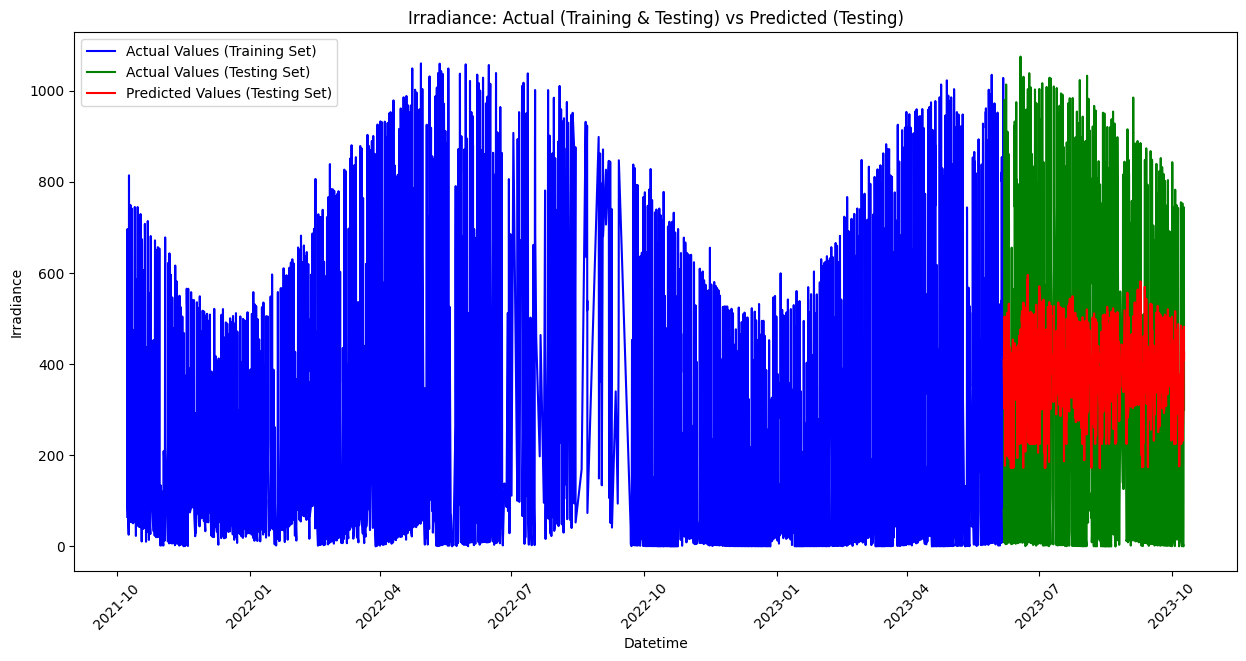

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming train_df and val_df are already created using the sequential split
# Predicting values for the validation set
predicted_irradiance = model.predict(val_generator).flatten()

# Add the predicted values to val_df
val_df['predicted_irradiance'] = predicted_irradiance

# Plotting
plt.figure(figsize=(15, 7))

# Plot actual values from the training set
plt.plot(train_df['datetime'], train_df['irradiance'], label='Actual Values (Training Set)', color='blue')

# Plot actual values from the testing set
plt.plot(val_df['datetime'], val_df['irradiance'], label='Actual Values (Testing Set)', color='green')

# Plot predicted values from the testing set
plt.plot(val_df['datetime'], val_df['predicted_irradiance'], label='Predicted Values (Testing Set)', color='red')

plt.title('Irradiance: Actual (Training & Testing) vs Predicted (Testing)')
plt.xlabel('Datetime')
plt.ylabel('Irradiance')
plt.legend()
plt.xticks(rotation=45)
plt.show()


### Model 3 With learning rate scheduler for efficient learning

Found 5767 validated image filenames.
Found 1442 validated image filenames.


Epoch 1/50
181/181 [==============================] - 78s 416ms/step - loss: 199431.0781 - mean_absolute_error: 352.7089 - mean_squared_error: 199431.0781 - val_loss: 252749.1406 - val_mean_absolute_error: 394.2655 - val_mean_squared_error: 252749.1406
Epoch 2/50
181/181 [==============================] - 70s 387ms/step - loss: 171518.2812 - mean_absolute_error: 321.1272 - mean_squared_error: 171518.2812 - val_loss: 222006.7656 - val_mean_absolute_error: 367.3057 - val_mean_squared_error: 222006.7656
Epoch 3/50
181/181 [==============================] - 78s 430ms/step - loss: 148306.2969 - mean_absolute_error: 295.6852 - mean_squared_error: 148306.2969 - val_loss: 196337.5938 - val_mean_absolute_error: 346.1166 - val_mean_squared_error: 196337.5938
Epoch 4/50
181/181 [==============================] - 72s 397ms/step - loss: 129204.4141 - mean_absolute_error: 275.8521 - mean_squared_error: 129204.4141 - val_loss: 174799.1875 - val_mean_absolute_error: 329.1904 - val_mean_squared_error: 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


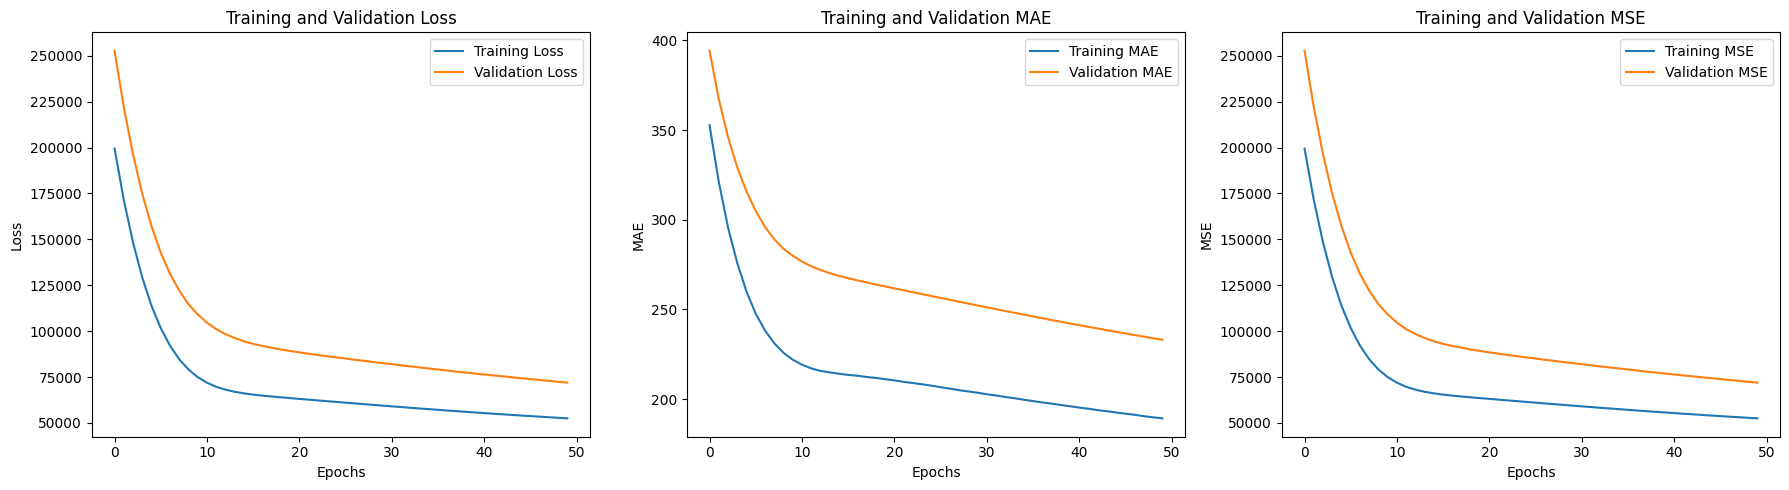

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# Reading the CSV file
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Image Dataset Curation/Image_Dataset_Final.csv")
df['datetime'] = pd.to_datetime(df['datetime'])

# Renaming the columns
df = df.rename(columns={'image_path': 'filename', 'Avg Global CMP22 (vent/cor) [W/m^2]': 'irradiance'})

# Sorting the values by datetime
df = df.sort_values(by='datetime')

# Splitting the data into training and validation sets
split_index = int(len(df) * 0.8)
train_df = df[:split_index]
val_df = df[split_index:]

# Data augmentation and preprocessing for training data
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
)

# Preprocessing for validation data (without augmentation)
val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
)

# Data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='irradiance',
    target_size=(224, 224),  # Resizing images
    batch_size=32,
    class_mode='raw',
    shuffle=False  # Important for time series data
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='irradiance',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    shuffle=False
)

# Load pre-trained MobileNetV3 model
base_model = tf.keras.applications.MobileNetV3Small(weights='imagenet', include_top=False)

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for regression
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(1)(x)  # 1 output neuron for regression
model = Model(inputs=base_model.input, outputs=output)

# Learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


# Compile the model with additional metrics
model.compile(optimizer='optimizer',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError()])


# Early stoppingand model checkpoint callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored metric
)


# Train the model
history = model.fit(train_generator, epochs=0,
                    validation_data=val_generator,
                    callbacks=[early_stopping])

# Save the model
model.save('/content/drive/MyDrive/Forecasting Models/MobileNetV3/mobilenetregressor.h5')

# Plotting Training and Validation Loss, MAE, and MSE
plt.figure(figsize=(18, 5))

# Plotting training and validation loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation MAE
plt.subplot(1, 3, 2)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

# Plotting training and validation MSE
plt.subplot(1, 3, 3)
plt.plot(history.history['mean_squared_error'], label='Training MSE')
plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()



In [ ]:
# Evaluate the model on validation dataset
val_loss, val_mae, val_mse = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation MAE: {val_mae}")
print(f"Validation MSE: {val_mse}")

46/46 [==============================] - 17s 367ms/step - loss: 71947.7031 - mean_absolute_error: 233.0248 - mean_squared_error: 71947.7031
Validation Loss: 71947.703125
Validation MAE: 233.02479553222656
Validation MSE: 71947.703125


46/46 [==============================] - 19s 375ms/step


<ipython-input-8-3c335db5f1f2>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['predicted_irradiance'] = predicted_irradiance


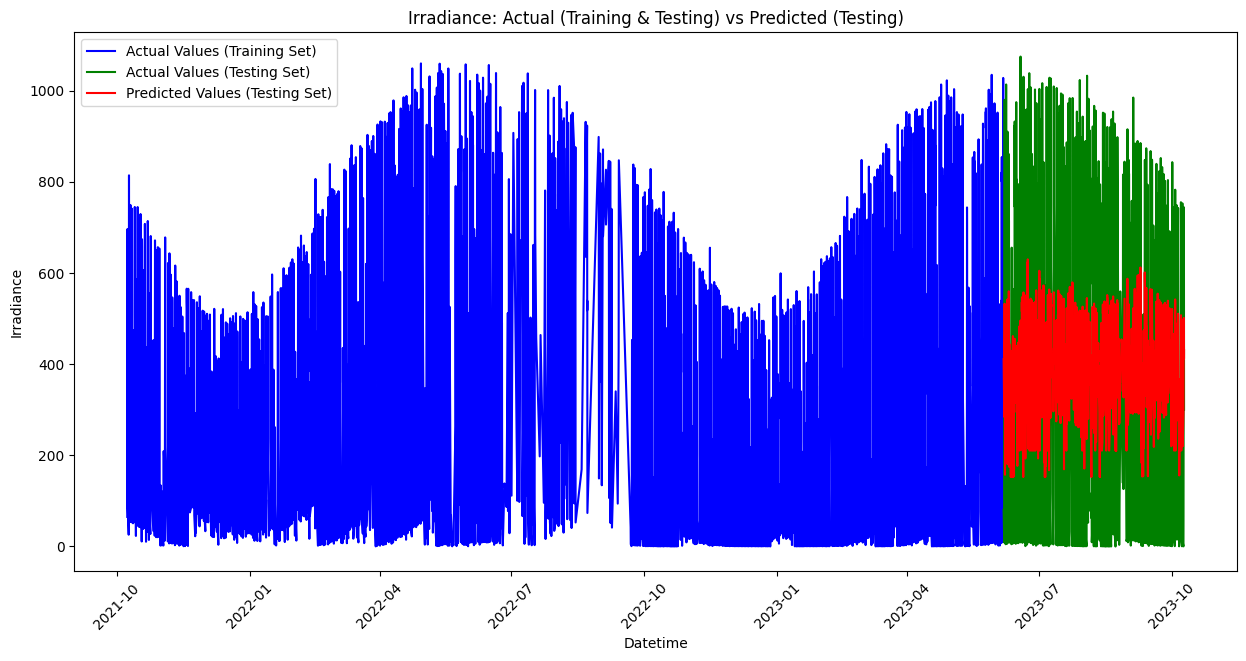

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming train_df and val_df are already created using the sequential split
# Predicting values for the validation set
predicted_irradiance = model.predict(val_generator).flatten()

# Add the predicted values to val_df
val_df['predicted_irradiance'] = predicted_irradiance

# Plotting
plt.figure(figsize=(15, 7))

# Plot actual values from the training set
plt.plot(train_df['datetime'], train_df['irradiance'], label='Actual Values (Training Set)', color='blue')

# Plot actual values from the testing set
plt.plot(val_df['datetime'], val_df['irradiance'], label='Actual Values (Testing Set)', color='green')

# Plot predicted values from the testing set
plt.plot(val_df['datetime'], val_df['predicted_irradiance'], label='Predicted Values (Testing Set)', color='red')

plt.title('Irradiance: Actual (Training & Testing) vs Predicted (Testing)')
plt.xlabel('Datetime')
plt.ylabel('Irradiance')
plt.legend()
plt.xticks(rotation=45)
plt.show()


### Model 4 - With MobileNetV3 Large

Found 5767 validated image filenames.
Found 1442 validated image filenames.


Epoch 1/200
181/181 [==============================] - 91s 475ms/step - loss: 195251.2500 - mean_absolute_error: 347.3189 - mean_squared_error: 195251.2500 - val_loss: 242997.6875 - val_mean_absolute_error: 385.4781 - val_mean_squared_error: 242997.6875
Epoch 2/200
181/181 [==============================] - 84s 463ms/step - loss: 160063.0156 - mean_absolute_error: 308.5540 - mean_squared_error: 160063.0156 - val_loss: 205390.2656 - val_mean_absolute_error: 353.4723 - val_mean_squared_error: 205390.2656
Epoch 3/200
181/181 [==============================] - 79s 438ms/step - loss: 132641.7188 - mean_absolute_error: 279.3414 - mean_squared_error: 132641.7188 - val_loss: 175907.9375 - val_mean_absolute_error: 330.4798 - val_mean_squared_error: 175907.9375
Epoch 4/200
181/181 [==============================] - 81s 448ms/step - loss: 112264.0547 - mean_absolute_error: 258.7576 - mean_squared_error: 112264.0547 - val_loss: 153574.5312 - val_mean_absolute_error: 314.0369 - val_mean_squared_err

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


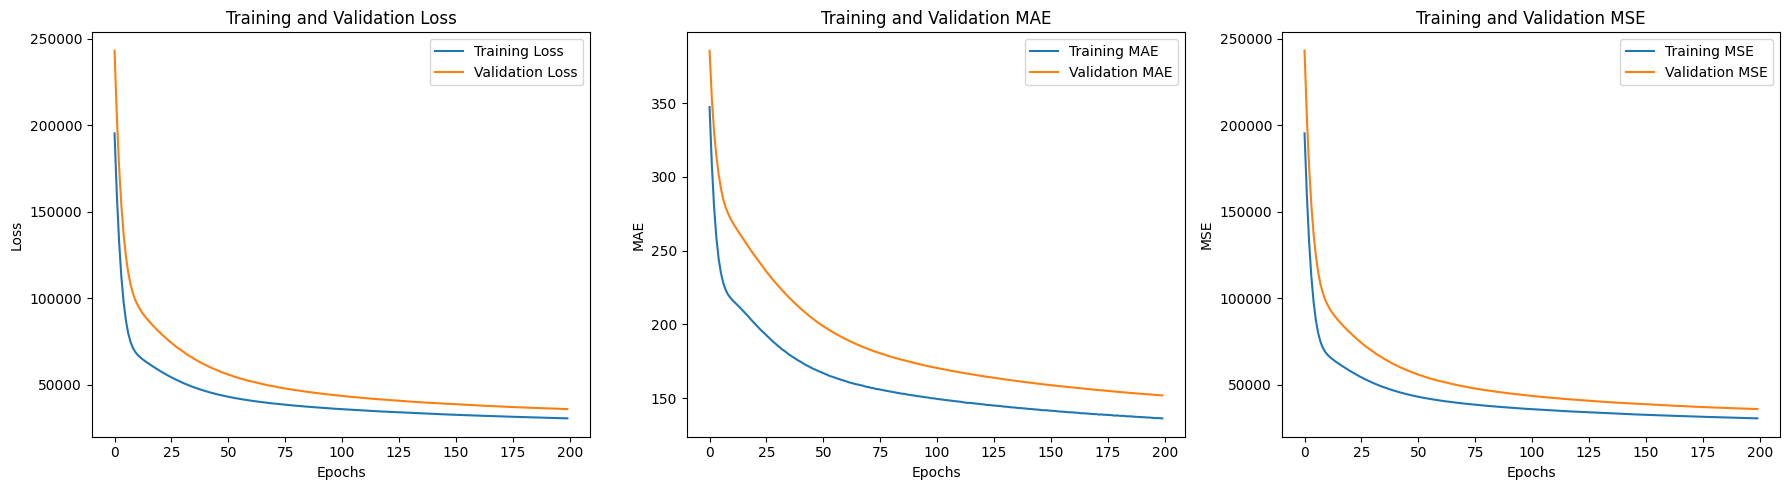

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# Reading the CSV file
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Image Dataset Curation/Image_Dataset_Final.csv")
df['datetime'] = pd.to_datetime(df['datetime'])

# Renaming the columns
df = df.rename(columns={'image_path': 'filename', 'Avg Global CMP22 (vent/cor) [W/m^2]': 'irradiance'})

# Sorting the values by datetime
df = df.sort_values(by='datetime')

# Splitting the data into training and validation sets
split_index = int(len(df) * 0.8)
train_df = df[:split_index]
val_df = df[split_index:]

# Data augmentation and preprocessing for training data
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
)

# Preprocessing for validation data (without augmentation)
val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
)

# Data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='irradiance',
    target_size=(224, 224),  # Resizing images
    batch_size=32,
    class_mode='raw',
    shuffle=False  # Important for time series data
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='irradiance',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    shuffle=False
)

# Load pre-trained MobileNetV3 model
base_model = tf.keras.applications.MobileNetV3Large(weights='imagenet', include_top=False)

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for regression
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(1)(x)  # 1 output neuron for regression
model = Model(inputs=base_model.input, outputs=output)


# # Learning rate scheduler
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-4,
#     decay_steps=10000,
#     decay_rate=0.9)

# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


# Compile the model with additional metrics
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError()])


# Early stoppingand model checkpoint callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored metric
)


# Train the model
history = model.fit(train_generator, epochs=200,
                    validation_data=val_generator,
                    callbacks=[early_stopping])

# Save the model
model.save('/content/drive/MyDrive/Forecasting Models/MobileNetV3/mobilenetregressor.h5')

# Plotting Training and Validation Loss, MAE, and MSE
plt.figure(figsize=(18, 5))

# Plotting training and validation loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation MAE
plt.subplot(1, 3, 2)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

# Plotting training and validation MSE
plt.subplot(1, 3, 3)
plt.plot(history.history['mean_squared_error'], label='Training MSE')
plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()



In [ ]:
# Evaluate the model on validation dataset
val_loss, val_mae, val_mse = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation MAE: {val_mae}")
print(f"Validation MSE: {val_mse}")

46/46 [==============================] - 15s 334ms/step - loss: 35894.6250 - mean_absolute_error: 151.9103 - mean_squared_error: 35894.6250
Validation Loss: 35894.625
Validation MAE: 151.91030883789062
Validation MSE: 35894.625


46/46 [==============================] - 16s 323ms/step


<ipython-input-13-3c335db5f1f2>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['predicted_irradiance'] = predicted_irradiance


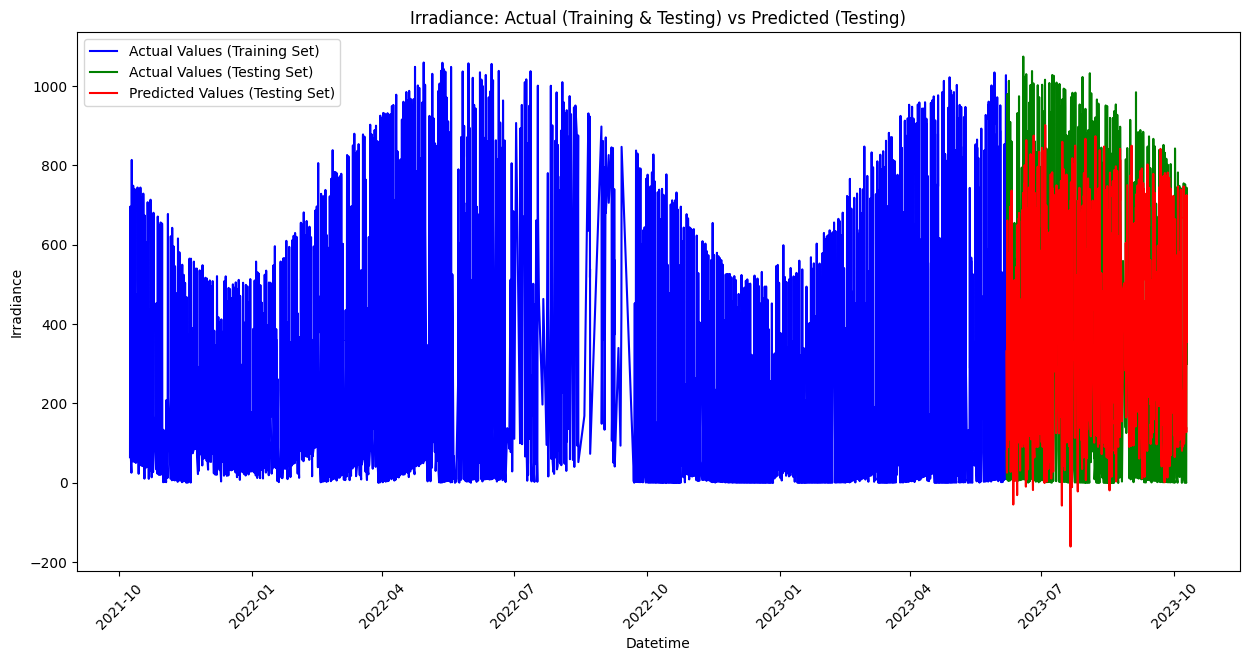

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming train_df and val_df are already created using the sequential split
# Predicting values for the validation set
predicted_irradiance = model.predict(val_generator).flatten()

# Add the predicted values to val_df
val_df['predicted_irradiance'] = predicted_irradiance

# Plotting
plt.figure(figsize=(15, 7))

# Plot actual values from the training set
plt.plot(train_df['datetime'], train_df['irradiance'], label='Actual Values (Training Set)', color='blue')

# Plot actual values from the testing set
plt.plot(val_df['datetime'], val_df['irradiance'], label='Actual Values (Testing Set)', color='green')

# Plot predicted values from the testing set
plt.plot(val_df['datetime'], val_df['predicted_irradiance'], label='Predicted Values (Testing Set)', color='red')

plt.title('Irradiance: Actual (Training & Testing) vs Predicted (Testing)')
plt.xlabel('Datetime')
plt.ylabel('Irradiance')
plt.legend()
plt.xticks(rotation=45)
plt.show()


### Loading Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# Reading the CSV file
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Image Dataset Curation/Image_Dataset_Final.csv")
df['datetime'] = pd.to_datetime(df['datetime'])

# Renaming the columns
df = df.rename(columns={'image_path': 'filename', 'Avg Global CMP22 (vent/cor) [W/m^2]': 'irradiance'})

# Sorting the values by datetime
df = df.sort_values(by='datetime')

# Splitting the data into training and validation sets
split_index = int(len(df) * 0.8)
train_df = df[:split_index]
val_df = df[split_index:]

# Data augmentation and preprocessing for training data
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
)

# Preprocessing for validation data (without augmentation)
val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
)

# Data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='irradiance',
    target_size=(224, 224),  # Resizing images
    batch_size=32,
    class_mode='raw',
    shuffle=False  # Important for time series data
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='irradiance',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    shuffle=False
)


Found 5767 validated image filenames.
Found 1442 validated image filenames.


In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import r2_score

# Load the saved model
model = tf.keras.models.load_model('/content/drive/MyDrive/Forecasting Models/MobileNetV3/mobilenetregressor.h5')

# Make predictions on the validation data
val_predictions = model.predict(val_generator)

# Actual values (targets)
val_targets = np.concatenate([y for x, y in val_generator], axis=0)

# Compute MSE and MAE
mse = tf.keras.metrics.mean_squared_error(val_targets, val_predictions).numpy().mean()
mae = tf.keras.metrics.mean_absolute_error(val_targets, val_predictions).numpy().mean()

# Compute RMSE
rmse = np.sqrt(mse)

# Compute R2 Score
r2 = r2_score(val_targets, val_predictions)

# Print the metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R2 Score:", r2)


46/46 [==============================] - 1169s 26s/step
